In [1]:
# Outage Duration Model (Conditional on Occurrence)

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


from pathlib import Path
BASE_DIR = Path().resolve()

DATA_PATH = BASE_DIR / "storms_data.csv"
df = pd.read_csv(DATA_PATH)

In [2]:
base_required = [
    "EVENT_ID",
    "BEGIN_DATE_TIME",
    "duration_hours",
    "housing_units",
    "cbp_emp_total",
    "n_points",
    "n_urban",
    "era_i10fg_max_total_48h",
    "era_tp_max_total_48h",
    "era_crr_max_total_48h",
]
missing = [c for c in base_required if c not in df.columns]
if missing:
    raise KeyError("Missing required columns:\n" + "\n".join(missing))

if "full_fips" not in df.columns:
    alt_fips = next((c for c in ["FIPS", "CZ_FIPS", "cz_fips", "county_fips"] if c in df.columns), None)
    if alt_fips is None:
        raise KeyError("Need a county id column: 'full_fips' or one of [FIPS, CZ_FIPS, cz_fips, county_fips].")
    df["full_fips"] = df[alt_fips]

df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], errors="coerce")
df = df[df["BEGIN_DATE_TIME"].notna()].copy()

df["event_time"] = df["BEGIN_DATE_TIME"]
df["month"] = df["event_time"].dt.month

def to_fips_str(x):
    try:
        return f"{int(float(x)):05d}"
    except Exception:
        return np.nan

df["fips_str"] = df["full_fips"].apply(to_fips_str)
df = df.dropna(subset=["fips_str"]).copy()


df["duration_hours"] = pd.to_numeric(df["duration_hours"], errors="coerce").fillna(0.0).clip(lower=0.0)

for c in [
    "housing_units", "cbp_emp_total", "n_points", "n_urban",
    "era_i10fg_max_total_48h", "era_tp_max_total_48h", "era_crr_max_total_48h",
    "overhead_circuits",
]:
    df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

feature_cols = [
    "era_i10fg_max_total_48h",
    "era_tp_max_total_48h",
    "era_crr_max_total_48h",
    'housing_units_by_area',
    "overhead_circuits",
    "n_points",
    "n_urban",
    "season_code",
    "cbp_emp_total",
]

group_cols = ["EVENT_ID", "fips_str"]

df_duration = (
    df.groupby(group_cols, as_index=False)
      .agg(target_duration_h=("duration_hours", "max"))
)

df_duration = df_duration[df_duration["target_duration_h"] > 0].copy()
print("Storm–county pairs with duration>0:", df_duration.shape[0])

hazard_cols = ["era_i10fg_max_total_48h", "era_tp_max_total_48h", "era_crr_max_total_48h"]
agg_dict = {}
for c in feature_cols:
    if c in hazard_cols:
        agg_dict[c] = "max"
    else:
        agg_dict[c] = "mean"
df_feat = (
    df.groupby(group_cols, as_index=False)
      .agg(agg_dict)
)

# Align with conditional sample set
df_feat = df_feat.merge(df_duration[group_cols], on=group_cols, how="inner")

# MERGE TARGET + FEATURES
df_model = df_duration.merge(df_feat, on=group_cols, how="left")

# Fill feature NaNs (after aggregation) consistently
df_model[feature_cols] = (
    df_model[feature_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

print("df_model:", df_model.shape)
print(df_model[group_cols + ["target_duration_h"]].head())

#TRAIN/TEST SPLIT + LOG1P
X = df_model[feature_cols].copy()
y = df_model["target_duration_h"].copy()
y_t = np.log1p(y)  # heavy-tail stabilization
X_train, X_test, y_train_t, y_test_t = train_test_split(
    X, y_t,
    test_size=0.25,
    random_state=42,
)

# Keep original-scale y for evaluation
y_test = y.loc[X_test.index]

# TRAIN MODEL
model_reg = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

model_reg.fit(X_train, y_train_t)

# EVALUATION (inverse transform to hours)
y_pred_t = model_reg.predict(X_test)
y_pred = np.expm1(y_pred_t).clip(min=0.0)
y_true = y_test.values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n===== Outage Duration Regression (conditional on occurrence) =====")
print(f"MAE  (hours) = {mae:.3f}")
print(f"RMSE (hours) = {rmse:.3f}")
print(f"R^2          = {r2:.3f}")

# FEATURE IMPORTANCE
feat_imp = (
    pd.DataFrame({"feature": feature_cols, "importance": model_reg.feature_importances_})
      .sort_values("importance", ascending=False)
)

print("\n===== Feature Importance =====")
print(feat_imp.to_string(index=False))

Storm–county pairs with duration>0: 3267
df_model: (3267, 12)
   EVENT_ID fips_str  target_duration_h
0    552410    34009               2.75
1    555915    34023               3.50
2    555981    36119              14.25
3    555982    36119              14.00
4    555984    34039              46.25

===== Outage Duration Regression (conditional on occurrence) =====
MAE  (hours) = 4.191
RMSE (hours) = 8.449
R^2          = 0.724

===== Feature Importance =====
                feature  importance
          cbp_emp_total    0.148675
               n_points    0.133685
            season_code    0.119196
                n_urban    0.113826
  housing_units_by_area    0.110106
      overhead_circuits    0.109434
   era_tp_max_total_48h    0.100161
  era_crr_max_total_48h    0.096516
era_i10fg_max_total_48h    0.068401


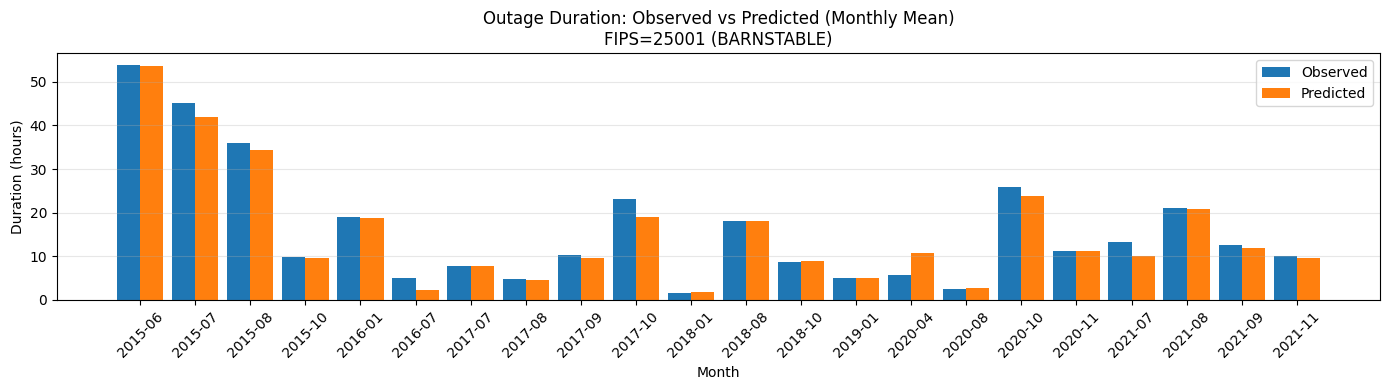

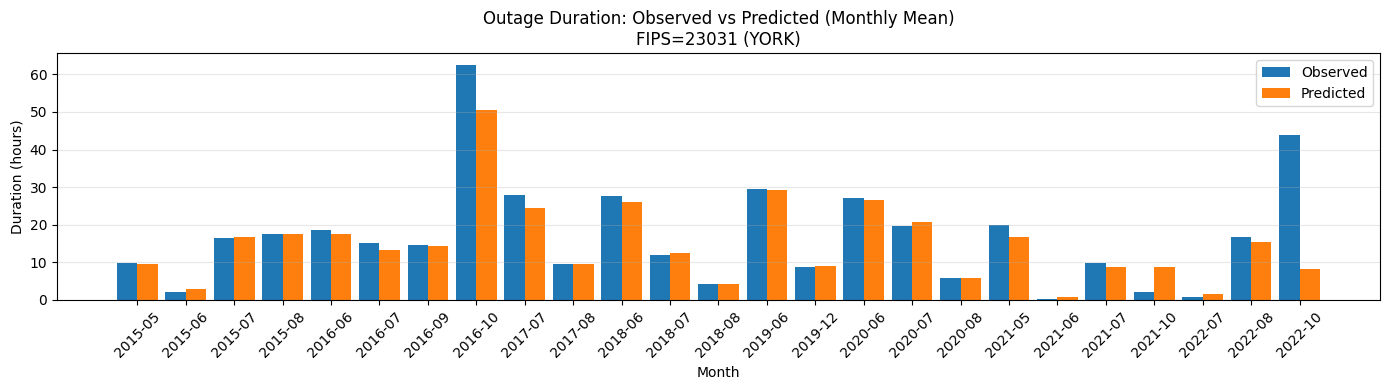

In [3]:
#  PREDICT ALL storm–county 
X_all = df_model[feature_cols].copy()
y_all_t_pred = model_reg.predict(X_all)
df_model["pred_duration_h"] = np.expm1(y_all_t_pred).clip(min=0.0)

# event_time to df_model (storm start time per storm–county)
storm_time = (
    df.groupby(["EVENT_ID", "fips_str"], as_index=False)
      .agg(event_time=("BEGIN_DATE_TIME", "min"))
)

df_model = df_model.merge(storm_time, on=["EVENT_ID", "fips_str"], how="left")
df_model["event_time"] = pd.to_datetime(df_model["event_time"], errors="coerce")
df_model = df_model[df_model["event_time"].notna()].copy()

#  monthly observed vs predicted duration
def plot_monthly_history_vs_pred_duration_bar(df_model, target_fips, title_suffix=""):
    target_fips = str(target_fips)
    d = df_model[df_model["fips_str"] == target_fips].copy()
    if d.empty:
        print(f"[Warn] No data for fips={target_fips}")
        return
    d = d.sort_values("event_time")
    d["month"] = d["event_time"].dt.to_period("M").dt.to_timestamp()
    m = (
        d.groupby("month", as_index=False)
         .agg(
             obs_mean=("target_duration_h", "mean"),
             pred_mean=("pred_duration_h", "mean"),
             n=("target_duration_h", "size"),
         )
         .sort_values("month")
    )
    x = np.arange(len(m))
    w = 0.42

    plt.figure(figsize=(14, 4))
    plt.bar(x - w/2, m["obs_mean"], width=w, label="Observed")
    plt.bar(x + w/2, m["pred_mean"], width=w, label="Predicted")

    plt.xticks(x, m["month"].dt.strftime("%Y-%m"), rotation=45)
    plt.xlabel("Month")
    plt.ylabel("Duration (hours)")
    plt.title(f"Outage Duration: Observed vs Predicted (Monthly Mean)\nFIPS={target_fips} {title_suffix}")
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_monthly_history_vs_pred_duration_bar(df_model, "25001", "(BARNSTABLE)")
plot_monthly_history_vs_pred_duration_bar(df_model, "23031", "(YORK)")